# HadCRUT5 ML TensorFlow Convolutional Neural Network Demo

The aim of this project is to try and predict the monthly temperature anomalie (tas_mean) with monthly lagged data. 
We will create the lagged data from our dataset and then train a convolutional neural network (cnn) on it. 
We will then compare our model's predictions to the target tas_mean. You might want to experiment with the project to see if you can improve model performance.

## Setup

In [1]:
import os
import joblib
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

In [2]:
# Some styling parameters. 
plt.style.use("fivethirtyeight")
plt.rcParams['lines.linewidth'] = 1
pd.set_option("display.float_format", "{:.2f}".format)
scatter_size = 4
scatter_alpha = 0.3
figsize = (15, 6)
titlesize = 18
labelsize = 14
cmap = "seismic"

## Load Data

In addition to the HadCRUT5 ensemble, a mean file is available that contains fields of the mean anomaly from the 200 ensemble members in each grid box. The 200 member HadCRUT5 ensemble has been constructed to allow exploration of the sensitivity of scientific analyses to the estimated uncertainties. If only the mean is used it will not be possible to explore the sensitivity to these uncertainties. 

**Manual Approach**
* Data used - HadCRUT5 analysis gridded data: additional fields: HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc
* Webpage: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/download.html
* Download link: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc
* This could be useful if the url / file names are changed in the future.

**Automated Approach**
* Or, run the code in the next cell to download, save and extract the data automatically.

In [3]:
file_path = "data/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc"

# Check if the file has already been downloaded, if not run the download_data.py script. 
if not os.path.exists(file_path):
    !python download_data.py

The dataset has dimensions of time, latitude and longitude. <br>
The dataset contains a data variable of "tas_mean" representing monthly temperature anomalies using Kelvin as the unit. 

In [4]:
# Use Xarray to open and store the dataset.
dataset = xr.open_dataset(file_path)
dataset

<xarray.Dataset> Size: 43MB
Dimensions:           (time: 2095, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 17kB 1850-01-16T12:00:00 ... 2024...
  * latitude          (latitude) float64 288B -87.5 -82.5 -77.5 ... 82.5 87.5
  * longitude         (longitude) float64 576B -177.5 -172.5 ... 172.5 177.5
    realization       int64 8B ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, latitude, longitude) float64 43MB ...
    time_bnds         (time, bnds) datetime64[ns] 34kB ...
    latitude_bnds     (latitude, bnds) float64 576B ...
    longitude_bnds    (longitude, bnds) float64 1kB ...
    realization_bnds  (bnds) int64 16B ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2024-09-02T14:38:01+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.2.0 HadSST.4.0.1.0
    title:        HadCRUT.5.0.2.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.2.0
    Conventions:  CF-1.7

In [5]:
# Check the variable unit type. 
dataset.tas_mean.units

'K'

In this Machine Learning demo we will explore Xarray's .to_dataframe() method which enables us to convert a multidimensional Xarray dataset to a Pandas Dataframe. If you are new to working with multidimensional data, this might provide an option to get started working with netcdf and other multidimensional dataset files. 

In [6]:
# Convert the Xarray dataset to a Pandas DataFrame.
df = dataset.to_dataframe()

In [7]:
df

tas_mean  time_bnds  \
time                latitude longitude bnds                        
1850-01-16 12:00:00 -87.50   -177.50   0          NaN 1850-01-01   
                                       1          NaN 1850-02-01   
                             -172.50   0          NaN 1850-01-01   
                                       1          NaN 1850-02-01   
                             -167.50   0          NaN 1850-01-01   
...                                               ...        ...   
2024-07-16 12:00:00 87.50    167.50    1         1.19 2024-08-01   
                             172.50    0         1.18 2024-07-01   
                                       1         1.18 2024-08-01   
                             177.50    0         1.16 2024-07-01   
                                       1         1.16 2024-08-01   

                                             latitude_bnds  longitude_bnds  \
time                latitude longitude bnds                                  
1850-01-16 12:00:00 -87.50   -177.50   0            -90.00         -180.00   
                                       1            -85.00         -175.00   
                             -172.50   0            -90.00         -175.00   
                                       1            -85.00         -170.00   
                             -167.50   0            -90.00         -170.00   
...                                                    ...             ...   
2024-07-16 12:00:00 87.50    167.50    1             90.00          170.00   
                             172.50    0             85.00          170.00   
                                       1             90.00          175.00   
                             177.50    0             85.00          175.00   
                                       1             90.00          180.00   

                                             realization  realization_bnds  
time                latitude longitude bnds                                 
1850-01-16 12:00:00 -87.50   -177.50   0             100                 1  
                                       1             100               200  
                             -172.50   0             100                 1  
                                       1             100               200  
                             -167.50   0             100                 1  
...                                                  ...               ...  
2024-07-16 12:00:00 87.50    167.50    1             100               200  
                             172.50    0             100                 1  
                                       1             100               200  
                             177.50    0             100                 1  
                                       1             100               200  

[10860480 rows x 6 columns]

As you can see above the DataFrame index is a matrix of dimensionality information, including time, latitude and longitude. Lets restructure out dataset.

In [8]:
# Identify the target variable we want to predict
TARGET = "tas_mean"

# Reset the index to convert index levels to columns
df_reset = df.reset_index()

# Now filter the Dataframe to include only the desired columns
feature_columns = ["time", "latitude", "longitude", TARGET]
df = df_reset[feature_columns]
df

,time,latitude,longitude,tas_mean
0,1850-01-16 12:00:00,-87.50,-177.50,NaN
1,1850-01-16 12:00:00,-87.50,-177.50,NaN
2,1850-01-16 12:00:00,-87.50,-172.50,NaN
3,1850-01-16 12:00:00,-87.50,-172.50,NaN
4,1850-01-16 12:00:00,-87.50,-167.50,NaN
...,...,...,...,...
10860475,2024-07-16 12:00:00,87.50,167.50,1.19
10860476,2024-07-16 12:00:00,87.50,172.50,1.18
10860477,2024-07-16 12:00:00,87.50,172.50,1.18
10860478,2024-07-16 12:00:00,87.50,177.50,1.16


<Axes: ylabel='Frequency'>

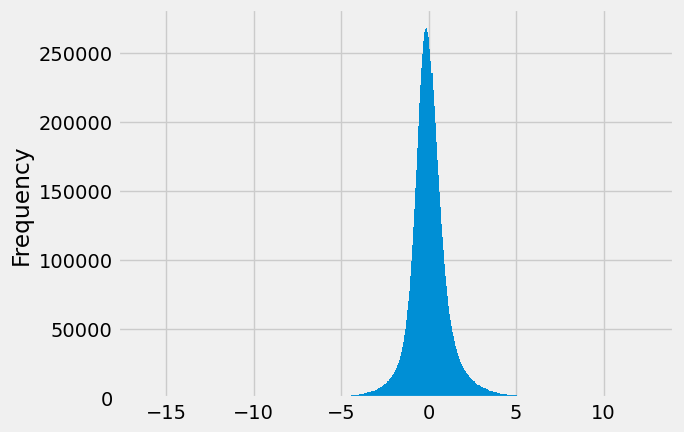

In [9]:
# Visualise the variable distribution. 
df[TARGET].plot(kind="hist", bins=500)

## Null Values

Lets review some of the key information about our dataset. 

In [10]:
df.describe()

,time,latitude,longitude,tas_mean
count,10860480,10860480.00,10860480.00,8661168.00
mean,1937-04-16 17:49:51.694513792,0.00,0.00,0.03
min,1850-01-16 12:00:00,-87.50,-177.50,-16.33
25%,1893-08-16 12:00:00,-43.75,-88.75,-0.55
50%,1937-04-16 00:00:00,0.00,0.00,-0.04
75%,1980-12-16 12:00:00,43.75,88.75,0.52
max,2024-07-16 12:00:00,87.50,177.50,12.61
std,NaN,51.94,103.91,1.25


Lets review how many null values we have in our dataset. As you can see ~20% of the tas values are null and will need removing or filling. 

In [11]:
# Calculate % of null values
(df.isna().sum() / df.shape[0]) * 100

time         0.00
latitude     0.00
longitude    0.00
tas_mean    20.25
dtype: float64

In [12]:
# Lets review our DataFrame shape to check how many values we have. 
df.shape

(10860480, 4)

As we have a high number of values lets drop the null values.

In [13]:
# Drop the null values from the dataset. 
df = df.dropna(subset=[TARGET])

# Check the shape again. 
df.shape

(8661168, 4)

## Visualise Data

It might be beneficial to visualise the data to check for outliers, check the distribution and understand it better. 

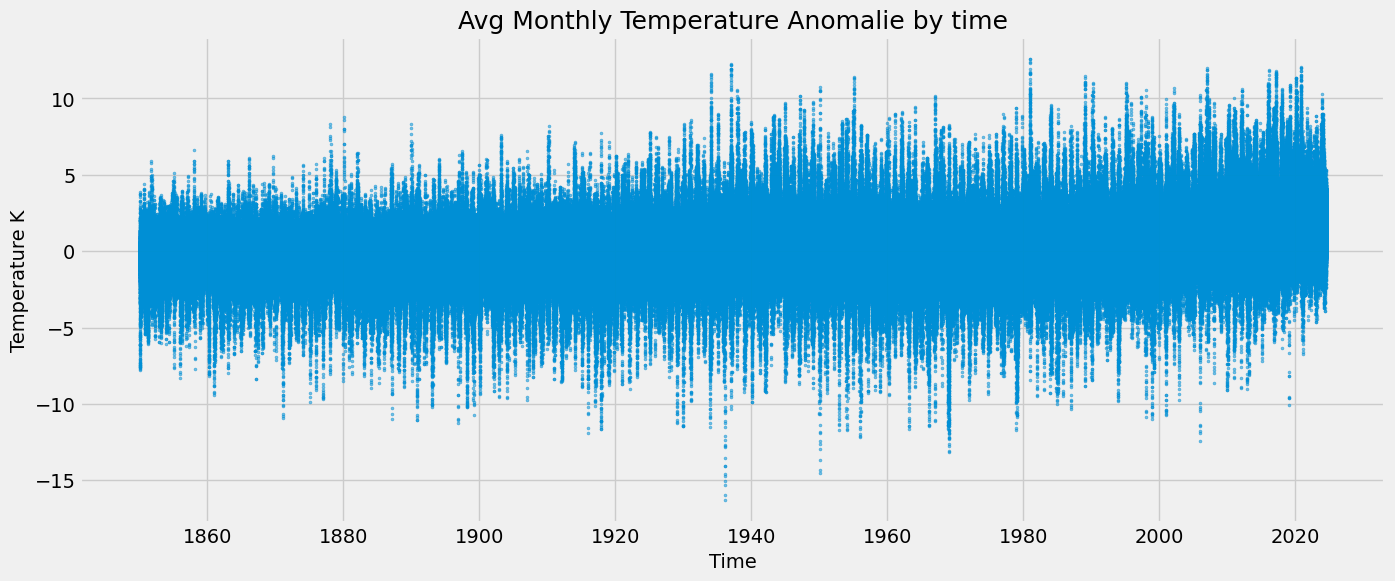

In [14]:
# Visualise the Dataset timeseries. 
plt.figure(figsize=figsize)
plt.scatter(df["time"], df[TARGET], s=scatter_size, alpha=scatter_alpha)
plt.title("Avg Monthly Temperature Anomalie by time", fontsize=titlesize)
plt.xlabel("Time", fontsize=labelsize)
plt.ylabel("Temperature K", fontsize=labelsize)
plt.show()

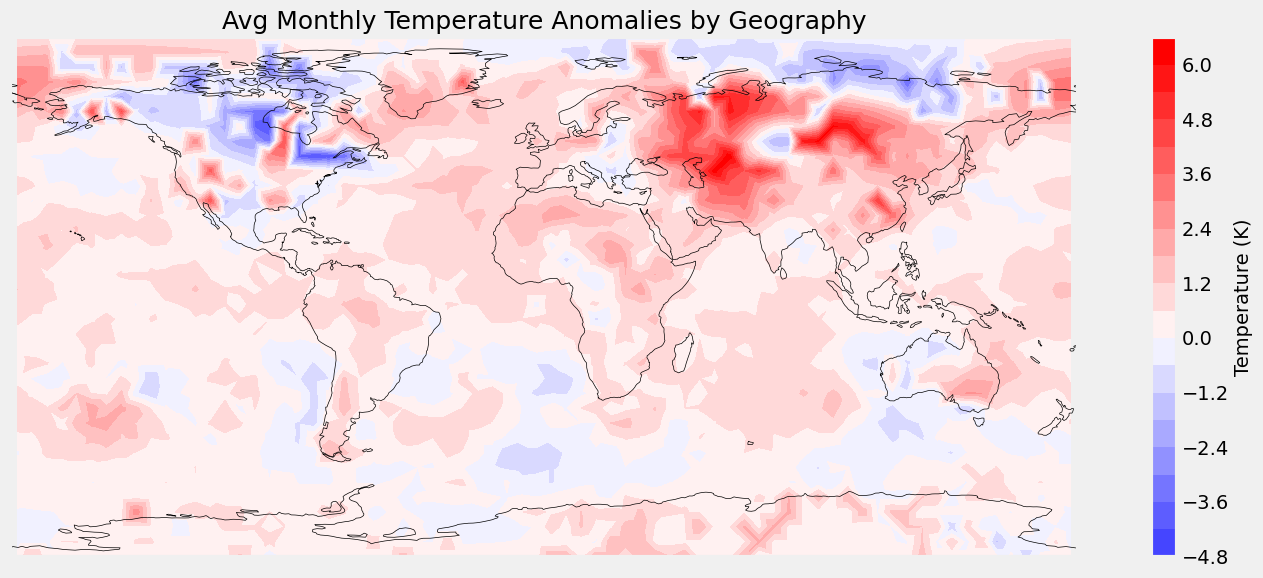

In [108]:
# Set the color limits based on the dataset

def create_tricontourf_chart(df, TARGET, figsize=figsize, titlesize=titlesize, labelsize=labelsize, cmpa=cmap):
    min_temp = df[TARGET].min()
    max_temp = -min_temp

    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={"projection": ccrs.PlateCarree()})

    # Set the extent and add coastlines for the single plot
    ax.set_extent([df.longitude.min(), df.longitude.max(), df.latitude.min(),  df.latitude.max()])  
    ax.coastlines()  

    # Plot the geographical distribution using tricontourf
    contour = ax.tricontourf(df.longitude, df.latitude, df[TARGET], 
                             levels=20, cmap=cmap, vmin=min_temp, vmax=max_temp, transform=ccrs.PlateCarree())

    # Set the title, labels, and colorbar
    ax.set_title('Avg Monthly Temperature Anomalies by Geography', fontsize=titlesize)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add the colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical')
    cbar.set_label('Temperature (K)', fontsize=labelsize)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
create_tricontourf_chart(df, TARGET)

## Time Series

### Set the dataframe index to the time column

In [76]:
# Check time column is of datetime datatype
df.loc[:, "time"] = pd.to_datetime(df["time"])

In [77]:
# Sort dataframe by date
df = df.sort_values(by='time')

In [78]:
# Set the time column to the dataframe index
df = df.set_index("time")
df

,latitude,longitude,tas_mean
time,,,
1850-01-16 12:00:00,-62.50,-112.50,0.11
1850-01-16 12:00:00,37.50,-62.50,1.01
1850-01-16 12:00:00,37.50,-67.50,0.74
1850-01-16 12:00:00,37.50,-67.50,0.74
1850-01-16 12:00:00,37.50,-72.50,0.57
...,...,...,...
2024-07-16 12:00:00,-27.50,-77.50,0.11
2024-07-16 12:00:00,-27.50,-82.50,0.42
2024-07-16 12:00:00,-27.50,-82.50,0.42


### Data Cut off point

We will reduce the size of the data by cutting off data pre 1950. This will help with the performance of this notebook for running on local machines.

In [79]:
cutoff_date = "1950-01-01"  # Replace with your desired cutoff date
df = df[df.index >= cutoff_date]
df.head(1)

,latitude,longitude,tas_mean
time,,,
1950-01-16 12:00:00,37.50,7.50,0.20


## Feature Creation

We could try and create more data for our model by providing date time information such as the month, quarter and year information and see if this is relevant. 

### Add date features

In [80]:
def create_features(df):
    """
    Create time series features based on time series index
    
    Parameters: 
    Pandas DataFrame where the index is a timeseries
    
    Return: 
    Pandas DataFrame with month, quarter and year features. 
    """
    df = df.copy()                           # Create a copy of the dataframe
    df.loc[:,"month"] = df.index.month       # Create a column called month and extract the month number from the time series index. 
    # Removed quarter as it is hindering model performance. 
    #df.loc[:,"quarter"] = df.index.quarter   # Create a column called quarter and extract the quarter number from the time series index. 
    df.loc[:,"year"] = df.index.year         # Create a column called year and extract the year from the time series index. 
    
    return df


In [81]:
# Call the function to add the month, quarter and year information to our dataframe. 
df = create_features(df)
df.shape

(4498128, 5)

### Add lag features

In [82]:
def add_lag_features(df, lag, num_of_lags):
    """
    Adds lag features to the DataFrame for time series analysis.

    This function creates lagged versions of the 'tas' column in the DataFrame.
    Each lagged column represents the 'tas' value shifted by a multiple of 364 days.

    Parameters:
    df: Pandas DataFrame containing a 'tas' column.
    lag: How long in days to lag the value from the original date.
    num_of_lags: Assign an amount of lag features to create. 
    gap: How long in days we want to have a gap from the current date to the start of the lag dates.

    Returns:
    Pandas DataFrame with added lag features.
    """
    
    # Loop the number of lag features
    for i in range(1, num_of_lags + 1):  
        # Create a new lag column using the loop index {i} to number it. 
        # Assign a value from tas which has been shifted by the lag amount * loop index + gap.
        df.loc[:,f"lag{i}"] = df.loc[:,"tas_mean"].shift(lag * i)
    
    return df

## Convolutional Neural Network Example

In [83]:
# We will cut off the data set to reduce its size to help with training speed for this  - feel free to change. 
cutoff_date = "2004-01-01"  
df = df[df.index >= cutoff_date]
df.head(1)

,latitude,longitude,tas_mean,month,year
time,,,,,
2004-01-16 12:00:00,32.50,-167.50,0.37,1,2004


### Create Features and Target column.

In [84]:
# Call the add_lag_features function above to add features to the df.
# This time we lag for a month (30 days) and create 13 lags (1 year + the following month which we want to predict) 
lag = 30
num_of_lags = 12

TARGET = "tas_mean"

# Add lag features, in this case we are adding 12, one per month.
df = add_lag_features(df=df, lag=lag, num_of_lags=num_of_lags)

# This process will create some NaN values, so lets remove them. 
df = df.dropna()
df

,latitude,longitude,tas_mean,month,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
time,,,,,,,,,,,,,,,,,
2004-01-16 12:00:00,42.50,-117.50,-0.34,1,2004,-2.70,1.42,0.82,0.08,1.06,0.61,0.46,0.39,0.66,0.08,-0.29,0.37
2004-01-16 12:00:00,42.50,-122.50,0.75,1,2004,0.19,1.42,0.76,1.08,1.06,0.53,0.46,-0.24,0.66,0.78,-0.29,0.37
2004-01-16 12:00:00,42.50,-122.50,0.75,1,2004,0.58,0.30,0.76,0.92,0.66,0.53,0.50,-0.24,0.71,0.78,-0.24,0.61
2004-01-16 12:00:00,42.50,-177.50,0.34,1,2004,1.16,0.28,0.66,0.92,0.66,0.35,0.50,0.10,0.71,0.66,-0.24,0.61
2004-01-16 12:00:00,37.50,177.50,1.11,1,2004,1.16,0.28,0.66,0.92,0.78,0.35,0.52,0.10,0.69,0.66,0.22,1.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 12:00:00,-27.50,-77.50,0.11,7,2024,0.20,1.06,0.70,0.51,1.17,0.43,0.67,0.96,0.93,0.39,1.01,-0.30
2024-07-16 12:00:00,-27.50,-82.50,0.42,7,2024,-0.03,0.93,0.82,0.34,0.75,0.50,0.69,1.20,0.98,0.70,0.90,-1.55
2024-07-16 12:00:00,-27.50,-82.50,0.42,7,2024,-0.03,0.93,0.82,0.34,0.75,0.50,0.69,1.20,0.98,0.70,0.90,-1.55


### Correlation Heatmap
We can use this technique to look for correlated features which may help use select the better features to use when trying to use them to predict the target.

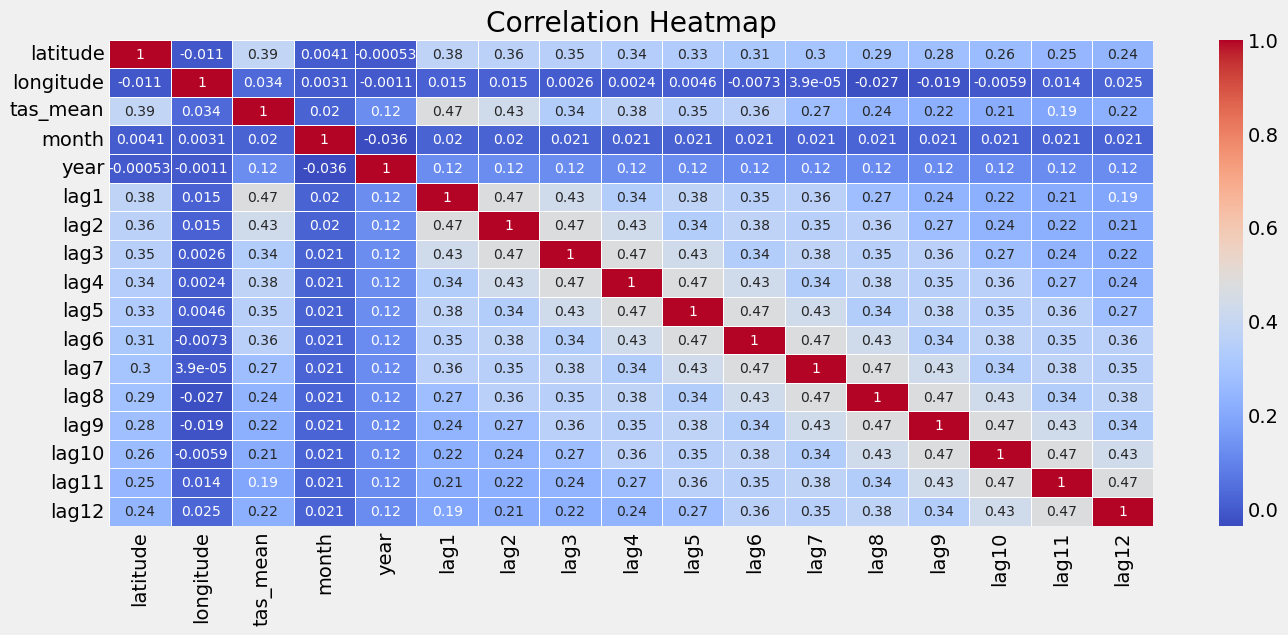

In [85]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=figsize)
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 10}, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [86]:
labels = df[TARGET]

features_to_drop = [TARGET, "month", "lag9", "lag10", "lag11", "lag12"]

df_features = df.drop(features_to_drop, axis=1)
FEATURES = df_features.columns
FEATURES

Index(['latitude', 'longitude', 'year', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8'],
      dtype='object')

### Train, test, split

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features, labels.values, test_size=0.2)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (1016396, 11), X_test: (254100, 11), y_train: (1016396,), y_test: (254100,)


### Scale our CNN features

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), index=X_train.index, columns=FEATURES)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), index=X_test.index, columns=FEATURES)

# Fit and transform the target variable
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Check the shapes of the scaled data
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

X_train_scaled

,latitude,longitude,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
time,,,,,,,,,,,
2017-11-16 00:00:00,1.00,1.13,0.54,0.37,-0.70,0.24,0.31,2.05,3.61,4.96,3.58
2022-03-16 12:00:00,-1.51,0.16,1.38,0.83,0.35,-1.16,-0.61,0.06,-0.38,0.61,-0.46
2014-01-16 12:00:00,1.49,-0.75,0.03,1.58,-1.67,0.16,1.32,-0.27,-0.11,-0.47,-0.34
2005-07-16 12:00:00,1.10,-0.90,-1.48,0.32,0.43,-0.63,-0.15,0.12,-0.74,1.09,-0.07
2013-02-15 00:00:00,-1.70,-1.09,-0.14,-1.67,-1.86,-1.40,-0.46,-0.52,-1.00,-1.86,-0.93
...,...,...,...,...,...,...,...,...,...,...,...
2010-10-16 12:00:00,0.33,-1.09,-0.64,0.08,-0.24,0.15,-0.32,-0.69,-1.27,-0.20,-0.36
2010-09-16 00:00:00,1.00,-1.00,-0.64,0.58,-1.42,0.17,-0.09,0.39,-0.67,0.07,0.00
2009-01-16 12:00:00,-0.93,-1.14,-0.81,1.18,-0.02,-0.78,-0.59,-1.03,-1.14,-0.84,-0.54


### Reshape our data for the Convolutional Neural Network

In [89]:
X_train_series = X_train_scaled.values.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_series = X_test_scaled.values.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
print("Train set shape", X_train_series.shape)
print("Test set shape", X_test_series.shape)

Train set shape (1016396, 11, 1)
Test set shape (254100, 11, 1)


### Create the Convolutional Neural Network

In [90]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Conv1D, MaxPooling1D

In [91]:
# Model and training Parameters
epochs = 40
batch = 64
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss = "mse"

In [92]:
# Create CNN model architecture. 

def create_cnn_model(X_train, kernel_size, strides, loss, optimizer):

    # Create a sequential model.
    model_cnn = Sequential()

    # Define the input shape of the data being processed. 
    model_cnn.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    # Add a 1 dimentional convolutional layer.
    model_cnn.add(Conv1D(filters=32, kernel_size=kernel_size, strides=strides, activation="tanh", padding="same"))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Dropout(0.3))

    # Add another Conv1D layer.
    model_cnn.add(Conv1D(filters=16, kernel_size=kernel_size, strides=strides, activation="tanh", padding="same"))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Dropout(0.1))

    model_cnn.add(Flatten())
    model_cnn.add(Dense(16, activation="relu"))
    model_cnn.add(Dropout(0.1))
    model_cnn.add(Dense(1))

    model_cnn.compile(loss=loss, optimizer=optimizer)
    model_cnn.summary()
    
    return model_cnn


# Call function to create model. 
model_cnn = create_cnn_model(X_train = X_train_series,
                             kernel_size=3,
                             strides=2,
                             loss=loss,
                             optimizer=optimizer                            
                             )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 6, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,969 (7.69 KB)

 Trainable params: 1,969 (7.69 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Create an early stopping object. 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = "val_loss", patience=5, verbose=1, mode="auto", restore_best_weights=True)

In [94]:
%%time

# Train a model

model_file_name = "HadCRUT5_TF_CNN_model.keras"    # File name to store and load the model once trained. 
run_cnn_training = True    # Change to either True / False to run training or not. 


def train_cnn_model(model, X_train, y_train, X_test, y_test, callbacks, epochs, batch_size):
    if run_cnn_training:

        cnn_history = model_cnn.fit(X_train_series, y_train_scaled, 
                                    callbacks=[early_stopping],
                                    validation_data=(X_test_series, y_test_scaled),
                                    epochs = epochs, 
                                    batch_size=batch)

        # Save the model
        model_cnn.save(model_file_name)
        return cnn_history
    
    
# Call training function.
cnn_history = train_cnn_model(model=model_cnn, 
                            X_train=X_train_series, 
                            y_train=y_train_scaled, 
                            X_test=X_test_series, 
                            y_test=y_test_scaled, 
                            callbacks=[early_stopping], 
                            epochs=epochs, 
                            batch_size=batch)

Epoch 1/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.6799 - val_loss: 0.6157
Epoch 2/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.6383 - val_loss: 0.6160
Epoch 3/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.6319 - val_loss: 0.5977
Epoch 4/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.6267 - val_loss: 0.5942
Epoch 5/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.6273 - val_loss: 0.5923
Epoch 6/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.6252 - val_loss: 0.5889
Epoch 7/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.6208 - val_loss: 0.5971
Epoch 8/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.6199 - val_loss: 0.5917
Epoch 9/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.6152 - val_loss: 0.5915
Epoch 10/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.6190 - val_loss: 0.5933
Epoch 11/40
15882/15882 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.6186 - val_loss: 0.58

### Load the model

In [95]:
from keras.models import load_model

# Load the model

loaded_cnn_model = load_model(model_file_name)
loaded_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 6, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,909 (23.09 KB)

 Trainable params: 1,969 (7.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,940 (15.39 KB)

### Visualise training loss

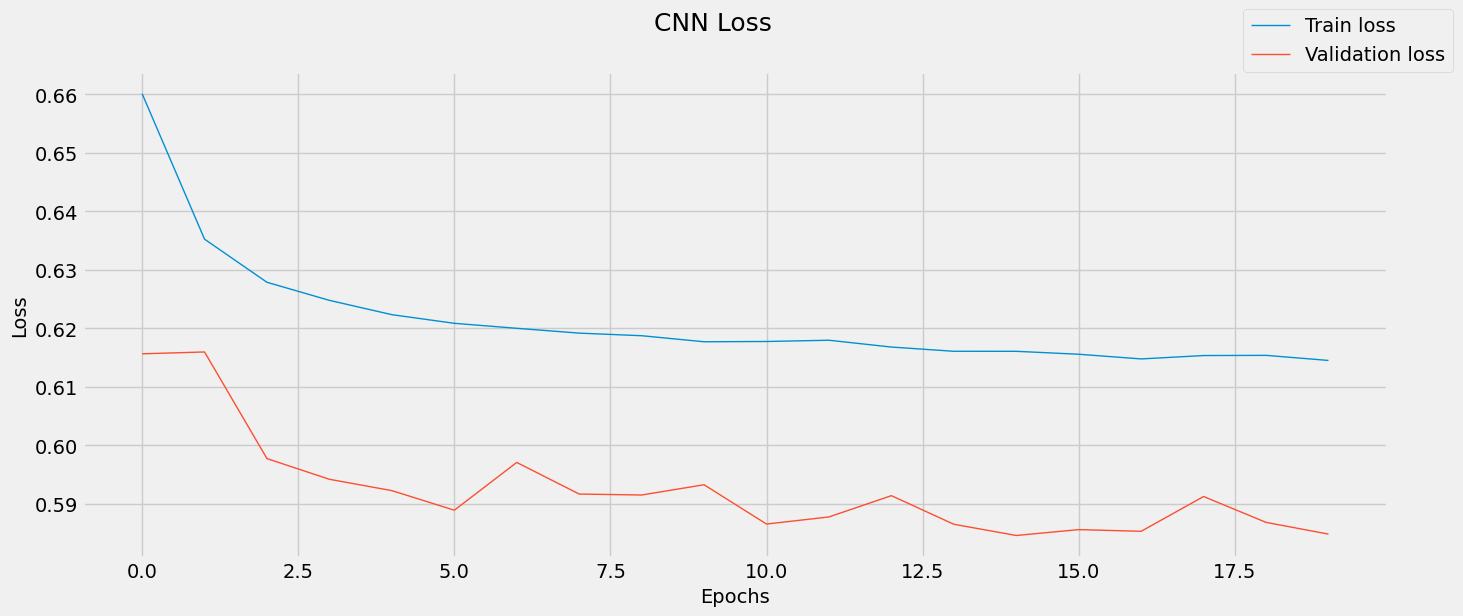

In [96]:
# Try and show the loss graph - this may not be possible if the model was loaded from a file and not trained. 

def plot_loss(history, figsize=figsize, titlesize=titlesize, labelsize=labelsize):
    try:
        fig = plt.figure(figsize=figsize)
        plt.plot(history.history["loss"], label="Train loss")
        plt.plot(history.history["val_loss"], label="Validation loss")
        fig.suptitle("CNN Loss", fontsize=titlesize)
        fig.legend()
        plt.xlabel("Epochs", fontsize=labelsize)
        plt.ylabel("Loss", fontsize=labelsize)
        plt.show()
    except NameError: 
        print("variable cnn_history not available - model probably loaded from file")
        
plot_loss(cnn_history)

### Predictions

In [97]:
# Create predicted results. 
cnn_train_predictions = loaded_cnn_model.predict(X_train_series)
cnn_test_predictions = loaded_cnn_model.predict(X_test_series)


31763/31763 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
7941/7941 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [98]:
# Inverse transform the original y_test values and the new predicted values. 
y_test_unscaled = scaler_y.inverse_transform(y_test_scaled) 
cnn_test_predictions_unscaled = scaler_y.inverse_transform(cnn_test_predictions)

In [99]:
X_test_scaled.describe()

,latitude,longitude,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8
count,254100.00,254100.00,254100.00,254100.00,254100.00,254100.00,254100.00,254100.00,254100.00,254100.00,254100.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.01,1.00,1.00,1.00
min,-1.70,-1.72,-1.65,-9.00,-9.11,-9.46,-9.47,-9.47,-9.46,-7.78,-9.11
25%,-0.83,-0.85,-0.81,-0.52,-0.53,-0.53,-0.53,-0.53,-0.53,-0.52,-0.53
50%,0.04,0.02,0.03,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16
75%,0.91,0.88,0.87,0.31,0.31,0.31,0.31,0.32,0.31,0.31,0.31
max,1.68,1.70,1.72,7.91,7.91,7.95,7.84,7.92,7.90,7.95,7.90


In [100]:
# Create a test DataFrame and add the predictions as a new column named 'prediction'
df_unscaled = pd.DataFrame(scaler_X.inverse_transform(X_test_scaled), index=X_test_scaled.index, columns=FEATURES)
df_unscaled.loc[:, TARGET] = y_test_unscaled
df_unscaled.loc[: , "cnn_prediction"] = cnn_test_predictions_unscaled


In [101]:
df_unscaled = df_unscaled.sort_index()
df_unscaled

,latitude,longitude,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,tas_mean,cnn_prediction
time,,,,,,,,,,,,,
2004-01-16 12:00:00,-87.50,-47.50,2004.00,0.41,0.67,0.34,0.37,-0.06,-0.51,-0.45,0.45,0.30,0.25
2004-01-16 12:00:00,77.50,-7.50,2004.00,-0.07,0.82,1.63,2.28,0.04,0.66,0.88,0.58,0.17,1.02
2004-01-16 12:00:00,-17.50,12.50,2004.00,-0.06,0.73,0.05,0.52,0.37,0.60,-0.40,0.88,0.82,0.47
2004-01-16 12:00:00,-52.50,122.50,2004.00,0.61,-0.15,0.73,0.61,0.41,-0.73,0.77,1.01,-0.52,0.40
2004-01-16 12:00:00,-42.50,87.50,2004.00,0.54,0.10,0.04,0.56,0.76,0.89,1.17,-0.95,0.87,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 12:00:00,2.50,47.50,2024.00,0.89,1.58,1.17,0.66,1.37,2.88,0.97,1.80,1.05,1.38
2024-07-16 12:00:00,72.50,-37.50,2024.00,0.72,0.77,0.62,0.93,0.92,1.30,1.84,1.20,0.74,1.58
2024-07-16 12:00:00,-12.50,-92.50,2024.00,2.98,2.58,3.21,2.11,3.57,1.36,2.44,3.24,0.42,1.40


### Visualise results

#### Compare time series actual temperature anomalies vs. predictions. 

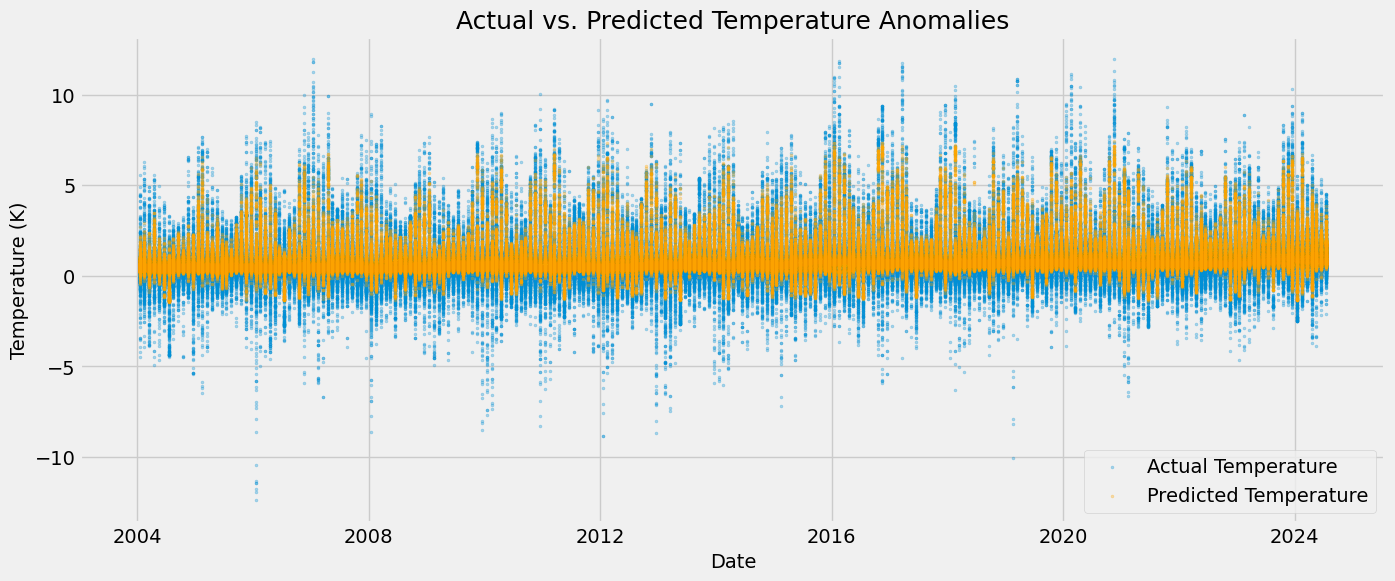

In [102]:
# Plot actual vs. predicted temperatures

def plot_true_vs_pred(df, figsize=figsize, scatter_size=scatter_size, scatter_alpha=scatter_alpha):
    plt.figure(figsize=figsize)
    plt.scatter(df.index, df[TARGET], label='Actual Temperature', s=scatter_size, alpha=scatter_alpha)
    plt.scatter(df.index, df["cnn_prediction"], label='Predicted Temperature', color='orange', s=scatter_size, alpha=scatter_alpha)
    plt.xlabel('Date', fontsize=labelsize)
    plt.ylabel('Temperature (K)', fontsize=labelsize)
    plt.title('Actual vs. Predicted Temperature Anomalies', fontsize=titlesize)
    plt.legend(loc="lower right")
    plt.show()
    
plot_true_vs_pred(df_unscaled)

Lets zoom in somewhere on the time index to see how our predictions compare.


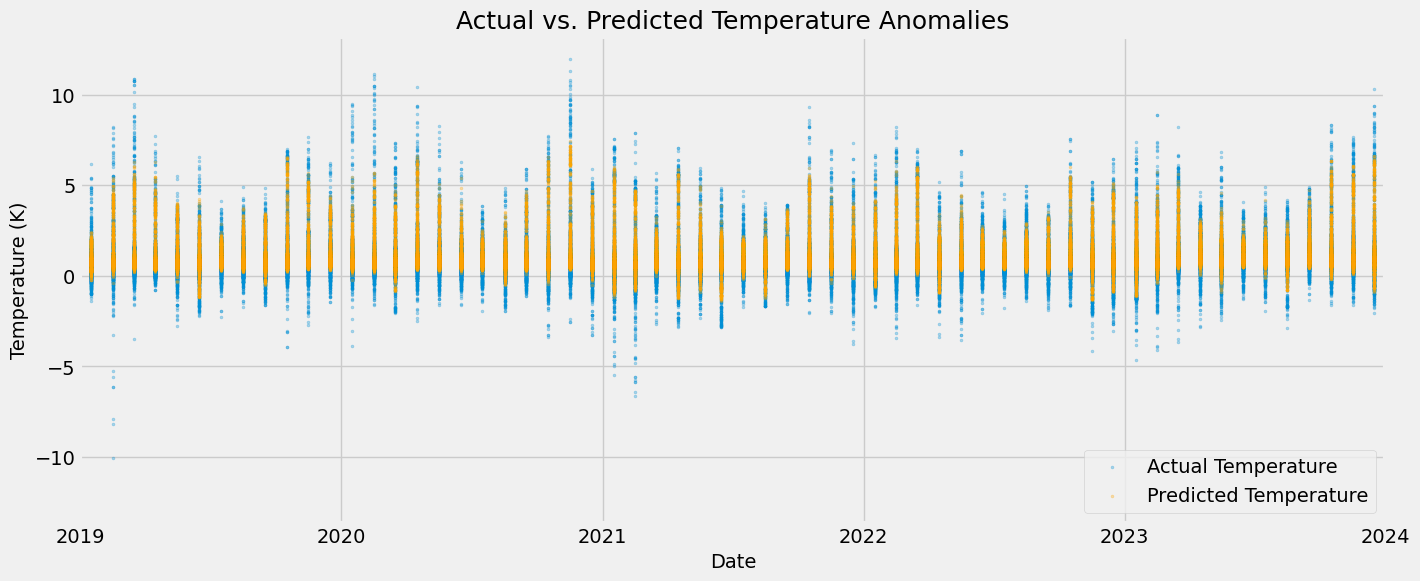

In [103]:
# Plot the true target values vs. the predicted values with zoomed x-axis

def plot_true_vs_pred_zoomed(df, xlim_min, xlim_max, figsize=figsize, scatter_size=scatter_size, scatter_alpha=scatter_alpha):
    plt.figure(figsize=figsize)
    plt.scatter(df.index, df[TARGET], label='Actual Temperature', s=scatter_size, alpha=scatter_alpha)
    plt.scatter(df.index, df["cnn_prediction"], label='Predicted Temperature', color='orange', s=scatter_size, alpha=scatter_alpha)
    plt.xlabel('Date', fontsize=labelsize)
    plt.ylabel('Temperature (K)', fontsize=labelsize)
    plt.title('Actual vs. Predicted Temperature Anomalies', fontsize=titlesize)

    # Use xlim and 2 timestamps to zoom in on specific date ranges. 
    plt.xlim(xlim_min, xlim_max)

    plt.legend()
    plt.show()
    
plot_true_vs_pred_zoomed(df_unscaled, pd.Timestamp('2019-01-01'), pd.Timestamp('2024-01-01'))


#### Visualise geographically

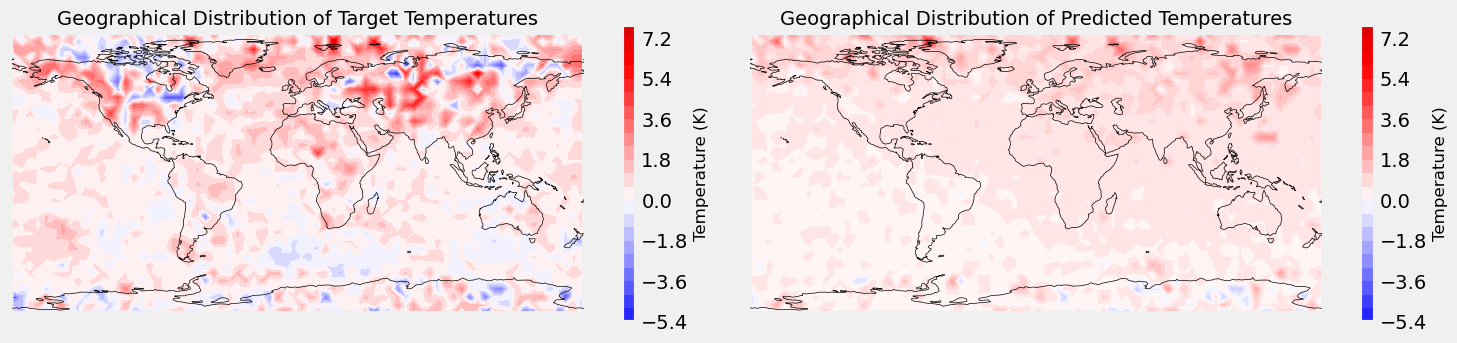

In [104]:
def plot_geographical_comparison(df, labelsize=12, titlesize=14, cmap=cmap):

    # Set the color limits across both datasets
    max_temp = max(df[TARGET].max(), df.cnn_prediction.max())
    min_temp = -max_temp

    fig, axs = plt.subplots(1,2, figsize=(15,3.5), subplot_kw={"projection": ccrs.PlateCarree()})

    # Set the extent and add coastlines for both subplots
    for ax in axs:
        ax.set_extent([df.longitude.min(), df.longitude.max(), df.latitude.min(),  df.latitude.max()])  # Set the extent of the map
        ax.coastlines()  # Add coastlines
        ax.set_xlabel('Longitude', fontsize=labelsize)
        ax.set_ylabel('Latitude', fontsize=labelsize)


    contour1 = axs[0].tricontourf(df.longitude, df.latitude, df[TARGET], 
                             levels=20, cmap=cmap,  vmin=min_temp, vmax=max_temp, transform=ccrs.PlateCarree())
    axs[0].set_title('Geographical Distribution of Target Temperatures', fontsize=titlesize)


    contour2 = axs[1].tricontourf(df.longitude, df.latitude, df.cnn_prediction, 
                             levels=20, cmap=cmap,  vmin=min_temp, vmax=max_temp, transform=ccrs.PlateCarree())
    axs[1].set_title('Geographical Distribution of Predicted Temperatures', fontsize=titlesize)


    # Add colorbars for both subplots
    cbar0 = plt.colorbar(contour1, ax=axs[0], orientation='vertical')
    cbar0.set_label('Temperature (K)', fontsize=labelsize)  

    cbar1 = plt.colorbar(contour1, ax=axs[1], orientation='vertical')
    cbar1.set_label('Temperature (K)', fontsize=labelsize)  

    plt.tight_layout()
    plt.show()
    
plot_geographical_comparison(df_unscaled)

#### Compare the actual average global temperature anomalies vs. predictions. 

In [105]:
# Collapse the values by mean average over the latitude and longitude. 

# Group by the datetime index and calculate the mean
averaged_df = df_unscaled.groupby(df_unscaled.index).mean()

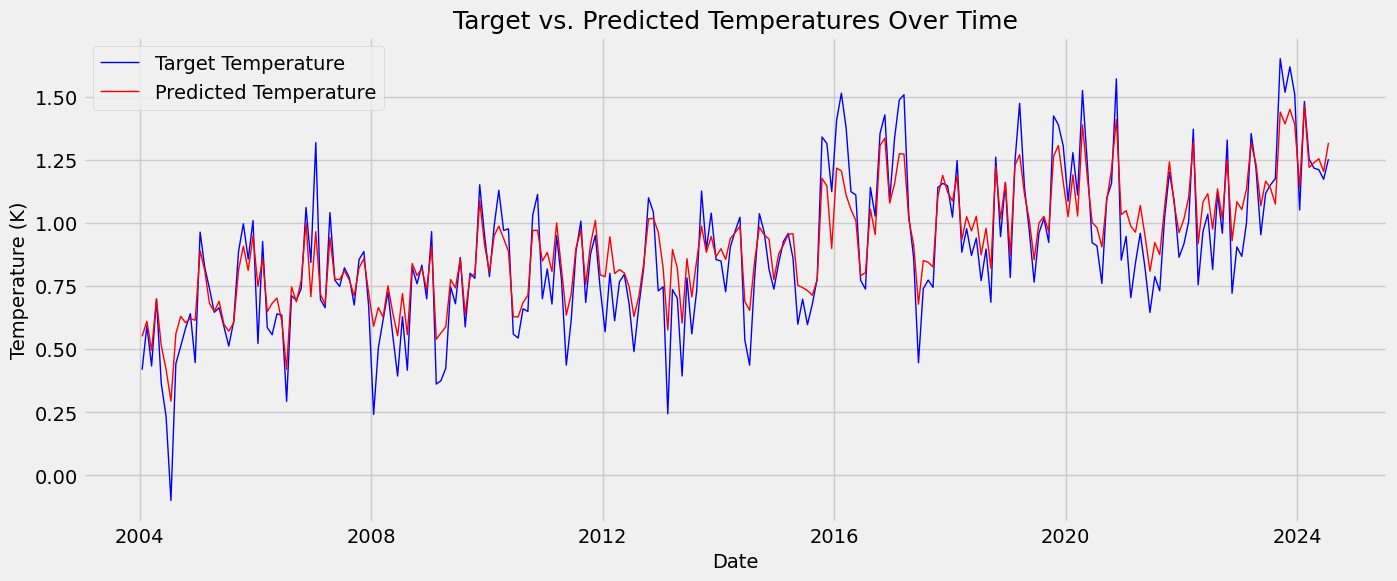

In [107]:
def plot_avg_mean(df, figsize=figsize, labelsize=labelsize, titlesize=titlesize):
    plt.figure(figsize=figsize)
    plt.plot(df.index, df[TARGET], label='Target Temperature', color='blue')
    plt.plot(df.index, df["cnn_prediction"], label='Predicted Temperature', color='red')
    plt.xlabel('Date', fontsize=labelsize)
    plt.ylabel('Temperature (K)', fontsize=labelsize)
    plt.title('Target vs. Predicted Temperatures Over Time', fontsize=titlesize)
    plt.legend()
    plt.show()
    
plot_avg_mean(averaged_df)

Our model makes predictions in the right direction, but needs improvement. Think about how you could improve this project.